In [3]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DXG Historical Data 1_6.csv')

In [5]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)
time_step = 100

x, y = create_dataset(df1, time_step)

X_train = x[:train_size-100]
X_test = x[train_size-100:]
y_train = y[:train_size-100]
ytest = y[train_size-100:]

In [10]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [11]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 4s 68ms/step - loss: 0.0128 - val_loss: 2.6484e-04
Epoch 2/100
21/21 [==============================] - 1s 45ms/step - loss: 0.0017 - val_loss: 4.2899e-04
Epoch 3/100
21/21 [==============================] - 1s 46ms/step - loss: 5.9511e-04 - val_loss: 2.2282e-04
Epoch 4/100
21/21 [==============================] - 1s 46ms/step - loss: 4.9999e-04 - val_loss: 2.2836e-04
Epoch 5/100
21/21 [==============================] - 1s 47ms/step - loss: 4.8185e-04 - val_loss: 2.0453e-04
Epoch 6/100
21/21 [==============================] - 1s 46ms/step - loss: 4.6945e-04 - val_loss: 2.2784e-04
Epoch 7/100
21/21 [==============================] - 1s 68ms/step - loss: 4.5652e-04 - val_loss: 1.9516e-04
Epoch 8/100
21/21 [==============================] - 2s 73ms/step - loss: 4.3421e-04 - val_loss: 1.9231e-04
Epoch 9/100
21/21 [==============================] - 2s 76ms/step - loss: 4.2094e-04 - val_loss: 1.8739e-04
Epoch 10/100
21/21 [================

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

5/5 [==============================] - 0s 16ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [15]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 18158.2358042536


In [16]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99841091951724
Testing MAE: 18110.758834807944


In [17]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.24957126379013062], [0.24776571989059448], [0.2459534853696823], [0.2441118210554123], [0.24224528670310974], [0.24035868048667908], [0.23845557868480682], [0.236538827419281], [0.23461070656776428], [0.23267297446727753], [0.23072707653045654], [0.2287743240594864], [0.22681565582752228], [0.22485187649726868], [0.22288388013839722], [0.2209121733903885], [0.21893732249736786], [0.21695980429649353], [0.21498002111911774], [0.21299833059310913], [0.211014986038208], [0.20903022587299347], [0.20704436302185059], [0.20505759119987488], [0.20306995511054993], [0.20108167827129364], [0.199092835187912], [0.1971035599708557], [0.1951139271259308], [0.19312404096126556], [0.19113394618034363], [0.18914367258548737], [0.18715329468250275], [0.18516287207603455], [0.18317243456840515], [0.18118201196193695], [0.17919155955314636], [0.17720119655132294], [0.17521095275878906], [0.17322076857089996], [0.17123067378997803], [0.16924072802066803], [0.16725093126296997], [0.16526123881340027],

In [18]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[16724.67087838],
       [16652.42944197],
       [16579.92030778],
       [16506.23366107],
       [16431.55194175],
       [16356.06712908],
       [16279.9223132 ],
       [16203.23136999],
       [16126.08551941],
       [16048.55511411],
       [15970.69798635],
       [15892.56660251],
       [15814.19852375],
       [15735.62594534],
       [15656.88463983],
       [15577.99487831],
       [15498.97931671],
       [15419.85703373],
       [15340.64412699],
       [15261.35490553],
       [15181.99950488],
       [15102.58746438],
       [15023.13130443],
       [14943.63877574],
       [14864.11166693],
       [14784.55892114],
       [14704.98351942],
       [14625.39082764],
       [14545.78382684],
       [14466.1666905 ],
       [14386.54120723],
       [14306.90856945],
       [14227.27175821],
       [14147.63315835],
       [14067.99396227],
       [13988.35536241],
       [13908.71557012],
       [13829.0793551 ],
       [13749.44790974],
       [13669.81884921],


In [19]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [20]:
print(y_pred_with_test_data.shape)
scaler.inverse_transform(test_data).shape

(260,)


(160, 1)

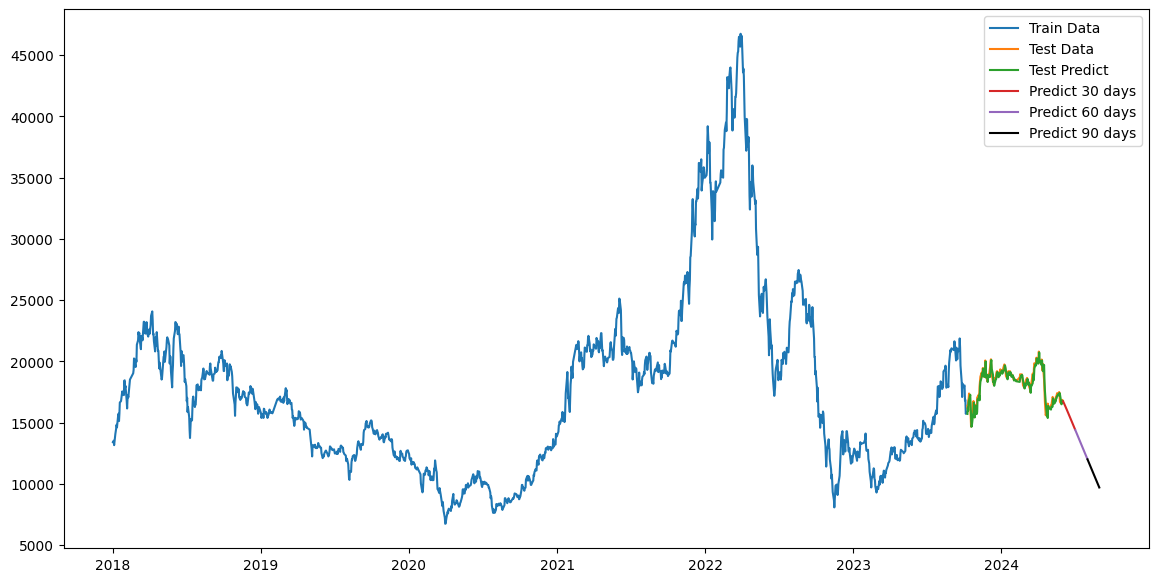

In [22]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred)], y_pred, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=30)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=30)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[30:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[60:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()